In [22]:
import keras
from keras.datasets import mnist
from keras.layers import Activation, Input, Embedding, LSTM, Dense, Lambda, GaussianNoise, concatenate
from keras.models import Model
import numpy as np
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Merge
from keras.optimizers import SGD, Adam, RMSprop
from keras.constraints import max_norm
from keras.layers import MaxPooling2D, Dropout, Dense, Flatten, Activation, Conv2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy
import matplotlib.pyplot as plt


### Load the data

In [2]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# convert y_train and y_test to categorical binary values 
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [3]:
X_train.shape

(60000, 28, 28)

### Preprocessing the data

In [13]:
# Reshape them to batch_size, width,height,#channels
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the values
X_train /= 255
X_test /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


### Define the teacher model

In [10]:
# Teacher model

input_shape = (28, 28, 1) # Input shape of each image

# Hyperparameters
nb_filters = 64 # number of convolutional filters to use
pool_size = (2, 2) # size of pooling area for max pooling
kernel_size = (3, 3) # convolution kernel size

teacher = Sequential()
teacher.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
teacher.add(Conv2D(64, (3, 3), activation='relu'))
teacher.add(MaxPooling2D(pool_size=(2, 2)))

teacher.add(Dropout(0.25)) # For reguralization

teacher.add(Flatten())
teacher.add(Dense(128, activation='relu'))
teacher.add(Dropout(0.5)) # For reguralization

teacher.add(Dense(nb_classes))
teacher.add(Activation('softmax')) # Note that we add a normal softmax layer to begin with

teacher.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(teacher.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

### Define the student model

In [72]:
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model

student = Sequential()
student.add(Flatten(input_shape=input_shape))
student.add(Dense(32, activation='relu'))
student.add(Dropout(0.2))
student.add(Dense(nb_classes))
student.add(Activation('softmax'))

#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
student.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

student.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
_________________________________________________________________
activation_9 (Activation)    (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


### Training the teacher model

In [14]:
# Train the teacher model as usual
epochs = 4
batch_size = 256
teacher.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 441s - loss: 0.4506 - acc: 0.8638 - val_loss: 0.1085 - val_acc: 0.9660
Epoch 2/4
60000/60000 [==============================] - 447s - loss: 0.1388 - acc: 0.9598 - val_loss: 0.0599 - val_acc: 0.9816
Epoch 3/4
60000/60000 [==============================] - 427s - loss: 0.1004 - acc: 0.9699 - val_loss: 0.0490 - val_acc: 0.9838
Epoch 4/4
60000/60000 [==============================] - 400s - loss: 0.0813 - acc: 0.9759 - val_loss: 0.0432 - val_acc: 0.9857


### Define a new model that outputs only teacher logits

In [54]:
# Raise the temperature of teacher model and gather the soft targets

# Set a tempature value
temp = 7

#Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(teacher.input, teacher.get_layer('dense_6').output)


### Define a manual softmax function

In [55]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())


### Understanding the concept of temperature in softmax activation

[[  2.02033917e-07   4.18666302e-09   4.88061801e-07   2.68463623e-07
    1.53939206e-09   3.20062921e-10   6.48316539e-11   9.99997616e-01
    1.76477108e-08   1.44751903e-06]]


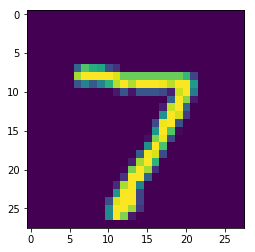

(0, 10)

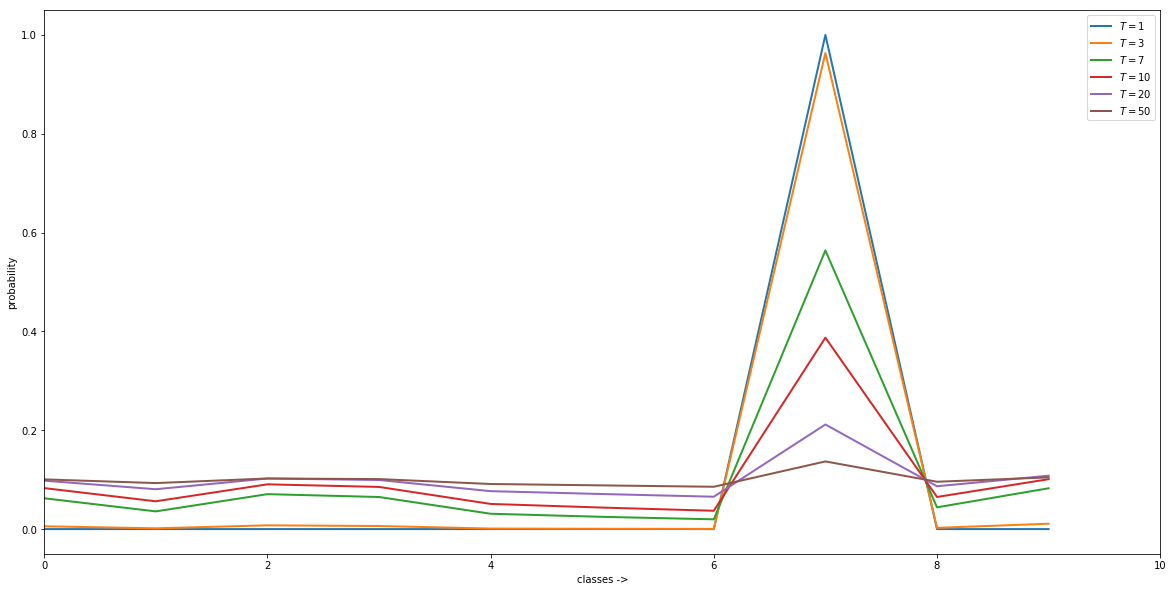

In [53]:
# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(X_test[0].reshape(1,28,28,1))
print(softmax(intermediate_output))

pixels = X_test[0]
pixels = pixels.reshape((28, 28))
plt.imshow(pixels)
plt.show()

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize=(20, 10));

temperature = [1,3,7,10,20,50]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=2);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 10]);
plt.show()

### Prepare the soft targets and the target data for student to be trained upon

In [56]:
teacher_train_logits = teacher_WO_Softmax.predict(X_train)
teacher_test_logits = teacher_WO_Softmax.predict(X_test) # This model directly gives the logits ( see the teacher_WO_softmax model above)

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/temp
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate so that this becomes a 10 + 10 dimensional vector
Y_train_new = np.concatenate([Y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([Y_test, Y_test_soft], axis =1)

In [63]:
Y_train_new.shape

(60000, 20)

In [64]:
Y_test_new.shape

(10000, 20)

In [65]:
X_train.shape

(60000, 28, 28, 1)

In [67]:
Y_train_new[0]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   6.05664525e-07,   1.08628274e-06,
         8.70400072e-07,   3.81800783e-06,   4.88270302e-07,
         5.61243723e-06,   1.05379627e-06,   1.02309161e-06,
         1.22876224e-06,   1.35615858e-06])

### Prepare the student model that outputs probabilities with and without temperature

In [73]:
# Remove the softmax layer from the student network
student.layers.pop()

# Now collect the logits from the last layer
logits = student.layers[-1].output # This is going to be a tensor. And hence it needs to pass through a Activation layer
probs = Activation('softmax')(logits)

# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model
student = Model(student.input, output)

student.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_5_input (InputLayer)     (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 784)           0           flatten_5_input[0][0]            
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 32)            25120       flatten_5[0][0]                  
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 32)            0           dense_9[0][0]                    
___________________________________________________________________________________________

### Declare knowledge distillation loss function

In [76]:
# This will be a teacher trained student model. 
# --> This uses a knowledge distillation loss function

# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

student.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] )
    


### Train the student model

In [77]:
student.fit(X_train, Y_train_new,
          batch_size=256,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test_new))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 1s - loss: 0.0366 - acc: 0.8950 - val_loss: 0.0270 - val_acc: 0.9242
Epoch 2/4
60000/60000 [==============================] - 1s - loss: 0.0350 - acc: 0.8993 - val_loss: 0.0261 - val_acc: 0.9266
Epoch 3/4
60000/60000 [==============================] - 1s - loss: 0.0337 - acc: 0.9030 - val_loss: 0.0251 - val_acc: 0.9270
Epoch 4/4
60000/60000 [==============================] - 1s - loss: 0.0326 - acc: 0.9055 - val_loss: 0.0242 - val_acc: 0.9301


In [78]:
# This is a standalone student model (same number of layers as original student model) trained on same data
# for comparing it with teacher trained student.

n_student = Sequential()
n_student.add(Flatten(input_shape=input_shape))
n_student.add(Dense(32, activation='relu'))
n_student.add(Dropout(0.2))
n_student.add(Dense(nb_classes))
n_student.add(Activation('softmax'))

#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
n_student.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])


In [79]:
n_student.fit(X_train, Y_train,
          batch_size=256,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 1s - loss: 1.0222 - acc: 0.6983 - val_loss: 0.4624 - val_acc: 0.8844
Epoch 2/4
60000/60000 [==============================] - 1s - loss: 0.5207 - acc: 0.8478 - val_loss: 0.3553 - val_acc: 0.9019
Epoch 3/4
60000/60000 [==============================] - 1s - loss: 0.4374 - acc: 0.8736 - val_loss: 0.3117 - val_acc: 0.9109
Epoch 4/4
60000/60000 [==============================] - 1s - loss: 0.3930 - acc: 0.8858 - val_loss: 0.2837 - val_acc: 0.9188
